In [2]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm
import torchvision.datasets as datasets
from datasets import load_dataset
from transformers import AutoImageProcessor, Dinov2ForImageClassification


In [3]:
ds = load_dataset("C:/Tesis/DatasetBinario", num_proc=3)
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "C:/Tesis/DatasetBinario/train")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg") or file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

Resolving data files:   0%|          | 0/20959 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1246 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [17]:
print(len(files))

20959


In [4]:
dinov2_vits14 = model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)
transform_image = T.Compose([
    T.Resize(244),                # Escala el lado más corto a 244 píxeles
    T.CenterCrop(224),            # Recorta una región central de 224x224
    T.ToTensor(),                 # Convierte la imagen a tensor
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliza con mean y std de ImageNet
])

Using cache found in C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [8]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [6]:
embeddings = compute_embeddings(files)

  0%|          | 0/20959 [00:00<?, ?it/s]

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from random import shuffle

y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

combined = list(zip(embedding_list, y))

# Barajar
shuffle(combined)

# Separar nuevamente
embedding_list, y = zip(*combined)
embedding_list = np.array(embedding_list).squeeze(1)  # Quita la dimensión de tamaño 1
 

In [22]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report

# # Supongamos que ya tienes tus embeddings y etiquetas en arrays
# # embedding_array: numpy array con tus datos de entrada
# # y_array: numpy array con tus etiquetas

# # Definir el modelo SVM
# svm = SVC()

# # Definir el espacio de búsqueda para los hiperparámetros
# param_grid = {
#     'C': [0.1, 1, 10, 100],             # Regularización
#     'gamma': [1, 0.1, 0.01, 0.001],    # Parámetro del kernel RBF
#     'kernel': ['rbf']                  # Usaremos kernel RBF en este ejemplo
# }

# # Configurar GridSearchCV
# grid_search = GridSearchCV(
#     estimator=svm,
#     param_grid=param_grid,
#     scoring='accuracy',                # Métrica de evaluación (puedes cambiarla según el problema)
#     cv=5,                              # Validación cruzada (5 pliegues en este caso)
#     verbose=2,
#     n_jobs=-1                          # Usar todos los núcleos disponibles
# )

# # Ejecutar la búsqueda de hiperparámetros
# grid_search.fit(embedding_list, y)

# # Imprimir los mejores hiperparámetros y la puntuación asociada
# print("Mejores hiperparámetros:", grid_search.best_params_)
# print("Mejor puntuación:", grid_search.best_score_)

# # Evaluar en datos de entrenamiento (opcional)
# y_pred = grid_search.best_estimator_.predict(embedding_list)
# print(classification_report(y, y_pred))


Evaluate

In [23]:
from sklearn.svm import SVC

svm = SVC(C = 10, gamma= 0.001, kernel= 'rbf')

svm.fit(embedding_list, y)

SVC(C=10, gamma=0.001)

In [24]:
from sklearn.metrics import classification_report, accuracy_score

In [14]:
ROOT_DIR = os.path.join(cwd, "C:/Tesis/DatasetBinario/test")


labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg") or file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

testfiles = labels.keys()
testembeddings = compute_embeddings(testfiles)

y_val = [labels[file] for file in testfiles]
#y_pred = svm.predict(np.array(list(testembeddings.values())).squeeze(1))

#print("Accuracy:", accuracy_score(y_val, y_pred))
#print("Classification Report:\n", classification_report(y_val, y_pred))



  0%|          | 0/1246 [00:00<?, ?it/s]

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(y_val, y_pred)

# Mostrar la matriz de confusión
labels_names = ds['train'].features['label'].names  # Nombres de las clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusión")
plt.show()

NameError: name 'y_val' is not defined

In [32]:
import joblib

# Guarda el modelo SVM entrenado
joblib.dump(grid_search.best_estimator_, "svm_dino_4_classes_model_binary_base.pkl")

['svm_dino_4_classes_model_binary_base.pkl']

In [28]:
import numpy as np

# Convierte a un array de numpy y guarda como archivo binario
np.save("embeddingsbinarybase.npy", np.array(list(embeddings.values())))
np.save("labelstestbinarybaset.npy", np.array(y))  # Guarda las etiquetas


In [7]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris  # Reemplaza con tu dataset
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_val_encoded = label_encoder.fit_transform(y_val)

# Crear el clasificador XGBoos

# Entrenar el modelo


# Define la función objetivo
def objective(trial):
    
    
    # Define los rangos para los hiperparámetros
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "n_jobs": -1
    }

    # Entrena el modelo
    model = XGBClassifier(**param_grid, eval_metric="logloss")
    model.fit(embedding_list, y_encoded)

    # Evalúa el modelo
    preds = model.predict(np.array(list(testembeddings.values())).reshape(-1, 384))
    accuracy = accuracy_score(y_val_encoded, preds)

    return accuracy  # Optuna maximiza esta métrica

# Configura el estudio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=-1)  # Ajusta n_trials según el tiempo disponible

# Resultados
print("Best trial parameters:", study.best_params)
print("Best trial accuracy:", study.best_value)



NameError: name 'y' is not defined

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris  # Reemplaza con tu dataset
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


model = XGBClassifier(n_estimators=495, 
                      max_depth=9, 
                      learning_rate= 0.07513291174284646, 
                      subsample=0.8103606987549683, 
                      colsample_bytree = 0.7897168158886071, 
                      gamma = 0.2932845334464851, 
                      reg_alpha = 8.968869453424377,
                      reg_lambda = 6.468487200733069, 
                      min_child_weight = 8)

model.fit(embedding_list, y_encoded)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7897168158886071, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2932845334464851,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07513291174284646,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=495, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
y_val_encoded = label_encoder.fit_transform(y_val)
y_pred = model.predict(np.array(list(testembeddings.values())).squeeze(1))

print("Accuracy:", accuracy_score(y_val_encoded, y_pred))
print("Classification Report:\n", classification_report(y_val_encoded, y_pred))

Accuracy: 0.8531300160513644
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83       485
           1       0.93      0.82      0.87       761

    accuracy                           0.85      1246
   macro avg       0.85      0.86      0.85      1246
weighted avg       0.87      0.85      0.85      1246



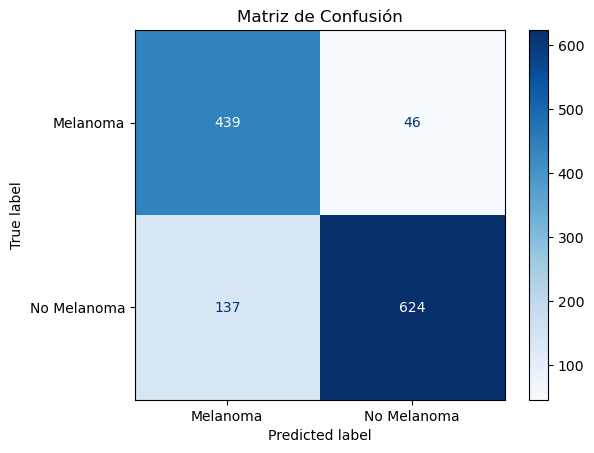

In [16]:
# Calcular matriz de confusión
cm = confusion_matrix(y_val_encoded, y_pred)

# Mostrar la matriz de confusión
labels_names = ds['train'].features['label'].names  # Nombres de las clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusión")
plt.show()

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(embedding_list)
X_test = scaler.transform(np.array(list(testembeddings.values())).squeeze(1))

# Definir el modelo KNN
k = 5  # Puedes probar diferentes valores de k
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')  # Métrica: euclidiana

# Entrenar el modelo
knn.fit(X_train, y)




KNeighborsClassifier(metric='euclidean')

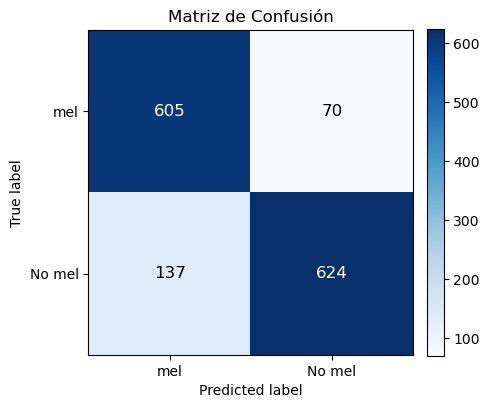

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix():
    # Definir la matriz de confusión
    conf_matrix = np.array([[605, 70], [137, 624]])

    # Definir etiquetas
    labels = ['mel', 'No mel']

    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(5, 5))

    # Crear la imagen de la matriz de confusión
    im = ax.imshow(conf_matrix, cmap=plt.cm.Blues)

    # Agregar la barra de color (mapa de calor) ajustando su tamaño
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Agregar etiquetas de los ejes
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # Etiquetas de los ejes
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Matriz de Confusión')

    # Agregar los valores dentro de la matriz
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            color = "white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black"
            ax.text(j, i, f"{conf_matrix[i, j]}", 
                    ha="center", va="center", color=color, fontsize=12)

    # Ajustar el diseño para que todo se vea correctamente alineado
    plt.tight_layout()
    plt.show()

# Llamar a la función para mostrar la matriz de confusión
plot_confusion_matrix()


In [31]:
!conda install -c conda-forge openblas


^C


In [30]:
# Predecir en el conjunto de prueba
y_pred = knn.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - KNN")
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

In [9]:
import lightgbm as lgb

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [13]:
ROOT_DIR = os.path.join(cwd, "C:\Thesis\DermaUH Challenge - Imágenes Evaluación")


labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg") or file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

testfiles = labels.keys()
testembeddings = compute_embeddings(testfiles)

y_val = [labels[file] for file in testfiles]


  0%|          | 0/1081 [00:00<?, ?it/s]

In [14]:
train_data = lgb.Dataset(embedding_list, label=y_encoded)
valid_data = lgb.Dataset(np.array(list(testembeddings.values())).squeeze(1), label=label_encoder.fit_transform(y_val), reference=train_data)

params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'verbose': 1
}


In [15]:
num_rounds = 100
model = lgb.train(params,
                  train_data,
                  num_rounds,
                  valid_sets=[valid_data])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 38591, number of used features: 768
[LightGBM] [Info] Start training from score -1.362709
[LightGBM] [Info] Start training from score -1.385543
[LightGBM] [Info] Start training from score -1.363114
[LightGBM] [Info] Start training from score -1.435556


In [21]:

y_pred = model.predict(np.array(list(testembeddings.values())).squeeze(1))
y_pred = np.argmax(y_pred, axis=1)
# Evaluar el modelo
print(classification_report(label_encoder.fit_transform(y_val), y_pred))

# Hacer predicciones





              precision    recall  f1-score   support

           0       0.71      0.53      0.61       138
           1       0.50      0.78      0.61       320
           2       0.85      0.59      0.70       590
           3       0.34      0.64      0.45        33

    accuracy                           0.64      1081
   macro avg       0.60      0.63      0.59      1081
weighted avg       0.71      0.64      0.65      1081



In [8]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Definir el modelo LightGBM
lgbm = lgb.LGBMClassifier()

# Definir el espacio de búsqueda para los hiperparámetros de LightGBM
param_grid = {
    'num_leaves': [50, 70],               # Número de hojas en el árbol
    'max_depth': [-1],                  # Profundidad máxima de los árboles
    'learning_rate': [0.1, 0.15],         # Tasa de aprendizaje
    'n_estimators': [50, 70],        # Número de árboles (estimadores)
    'subsample': [0.6, 0.8],               # Fracción de datos a usar para cada árbol
    'colsample_bytree': [0.8, 1],       # Fracción de características para cada árbol
    'min_child_samples': [50, 70]          # Mínimo número de muestras en una hoja
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='accuracy',                       # Métrica de evaluación (puedes cambiarla según el problema)
    cv=4,                                     # Validación cruzada (5 pliegues en este caso)
    verbose=2,
    n_jobs=-1                                  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(embedding_list, y)

# Imprimir los mejores hiperparámetros y la puntuación asociada
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

# Evaluar en datos de entrenamiento (opcional)
y_pred = grid_search.best_estimator_.predict(embedding_list)
print(classification_report(y, y_pred))


Fitting 4 folds for each of 64 candidates, totalling 256 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 38591, number of used features: 768
[LightGBM] [Info] Start training from score -1.362709
[LightGBM] [Info] Start training from score -1.385543
[LightGBM] [Info] Start training from score -1.363114
[LightGBM] [Info] Start training from score -1.435556
Mejores hiperparámetros: {'colsample_bytree': 1, 'learning_rate': 0.15, 'max_depth': -1, 'min_child_samples': 70, 'n_estimators': 70, 'num_leaves': 70, 'subsample': 0.6}
Mejor puntuación: 0.8426576275828623
              precision    recall  f1-score   support

         bcc       1.00      1.00      1.00      9878
         mel       1.00      0.99      0.99      9655
      others       0.99      0.99      0.99      9874
      

In [27]:
from sklearn.metrics import classification_report, accuracy_score

y_val_encoded = label_encoder.fit_transform(y_val)
y_pred = model.predict(np.array(list(testembeddings.values())).squeeze(1))

print("Accuracy:", accuracy_score(y_val_encoded, y_pred))
print("Classification Report:\n", classification_report(y_val_encoded, y_pred))

NameError: name 'accuracy_score' is not defined